In [74]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.utils import shuffle
from IPython.display import clear_output

In [2]:
data_dir = r"D:\training_data"
label = -1

X_filenames = []
Y_labels = []

# data_dir
# -- cancer
# ---- _.oct.csv
# -- non_cancer
# ---- _.oct.csv

# iter_0
# subdir = [data_dir]
# dirs = [cancer, non_cancer]
# files = []

# iter_1
# subdir = data_dir/cancer
# dirs = []
# files [_0000.oct.csv, _0001.oct.csv, etc.]

for subdir, dirs, files in os.walk(data_dir):
    print("%s: %s" %(subdir, label))

    for file in files:
        full_path = os.path.join(subdir, file)
        X_filenames.append(full_path)
        Y_labels.append(label)

    label += 1

Y_labels = tf.keras.utils.to_categorical(Y_labels) # 0/cancerous -> [1 0], 1/non-cancerous -> [0 1]
X_filenames, Y_labels = shuffle(X_filenames, Y_labels)
X_train_filenames, X_val_filenames, Y_train, Y_val = train_test_split(X_filenames, Y_labels, test_size=0.2, random_state=1)

print(len(X_filenames))
print(len(Y_labels))
print(len(X_train_filenames))
print(len(X_val_filenames))
print(len(Y_train))
print(len(Y_val))

D:\training_data: -1
D:\training_data\high_grade_cancer: 0
D:\training_data\non_cancer: 1
8573
8573
6858
1715
6858
1715


429
(320, 100, 100, 1)
(320, 2)


<Figure size 432x288 with 0 Axes>

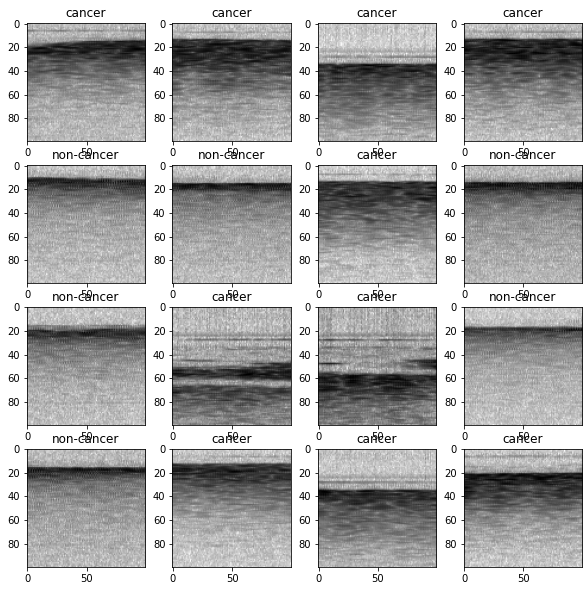

In [3]:
# returns list of B_frame slices from left to right
def slice_bframe(B_frame, slice_width, num_slices):
    slices = []

    for i in range(num_slices):
        slice = B_frame[:, i*slice_width:(i+1)*slice_width]
        slice = resize(slice, (slice_width, slice_width))
        slices.append(slice)

    return slices

class Batch_Generator(tf.keras.utils.Sequence):
  def __init__(self, filenames, labels, batch_size, slice_width, num_slices):
    self.filenames = filenames
    self.labels = labels
    self.batch_size = batch_size
    self.slice_width = slice_width
    self.num_slices = num_slices

  # returns the number of B_frame batches in the training data
  # 1 B_frame batch = num_slices training examples
  def __len__(self):
    return np.ceil(len(self.filenames) / self.batch_size).astype(int)
  
  # returns the inputs and labels for the kth B_frame batch
  def __getitem__(self, k):
    start = k*self.batch_size
    stop = (k+1)*self.batch_size 
    batch_filenames = self.filenames[start:stop]
    batch_labels = self.labels[start:stop]

    batch_X = []
    batch_Y = []
    file_num = 0

    for file in batch_filenames:
      B_frame = pd.read_csv(file, header=None).to_numpy()
      B_frame = B_frame[300:1200, :] # truncate to relevant portion of A-line
      frame_label = batch_labels[file_num]

      batch_X = batch_X + slice_bframe(B_frame, self.slice_width, self.num_slices)
      batch_Y = batch_Y + [frame_label] * self.num_slices # all slices have the same label
      batch_X, batch_Y = shuffle(batch_X, batch_Y)
  
      file_num += 1

    return np.expand_dims(np.stack(batch_X, axis=0), axis=3), np.stack(batch_Y, axis=0)
  
batch_size = 16
slice_width = 100
num_slices = 20
batch_generator = Batch_Generator(X_train_filenames, Y_train, batch_size, slice_width, num_slices)
print(batch_generator.__len__())

x, y = batch_generator.__getitem__(0)
print(x.shape)
print(y.shape)

plt.tight_layout()
plt.subplots(4,4, figsize=(10,10))
step = 5

for i in range(16):
  plt.subplot(4,4,i+1)
  input = x[i*step, :, :]
  label = y[i*step]

  if(label[0]==1):
    title = "cancer"
  else:
    title = "non-cancer"

  plt.title(title)
  plt.imshow(input, cmap="gray")
  
plt.show()

val_batch_generator = Batch_Generator(X_val_filenames, Y_val, batch_size, slice_width, num_slices)

In [19]:
# load some batches into RAM for network prototyping

X_train = []
Y_train = []

num_batches = 32

for i in range(num_batches):
    x, y = batch_generator.__getitem__(i)
    X_train.append(x)
    Y_train.append(y)

X_train, Y_train = np.stack(X_train, axis=0), np.stack(Y_train, axis=0)
X_train, Y_train = np.reshape(X_train, (num_batches*320, 100, 100, 1)), np.reshape(Y_train, (num_batches*320, 2))

print(X_train.shape)
print(Y_train.shape)

(10240, 100, 100, 1)
(10240, 2)


In [24]:
class OCT_Classifier(tf.keras.Model):
    # initialize layers used in the model (order unimportant)
    def __init__(self, filter_size, activation, padding):
        super().__init__()
        # convolutional layers
        self.c1 = tf.keras.layers.Conv2D(96, 8, strides=2, activation=activation, padding=padding)
        self.p1 = tf.keras.layers.MaxPooling2D(filter_size, strides=2)
        self.c2 = tf.keras.layers.Conv2D(256, filter_size, strides=1, activation=activation, padding=padding)
        self.p2 = tf.keras.layers.MaxPooling2D(filter_size, strides=2)
        self.c3 = tf.keras.layers.Conv2D(384, filter_size, strides=1, activation=activation, padding=padding)
        self.c4 = tf.keras.layers.Conv2D(384, filter_size, strides=1, activation=activation, padding=padding)
        self.c5 = tf.keras.layers.Conv2D(256, filter_size, strides=1, activation=activation, padding=padding)
        self.p3 = tf.keras.layers.MaxPooling2D(filter_size, strides=2)
        
        # dense layers
        self.f1 = tf.keras.layers.Flatten()
        self.f2 = tf.keras.layers.Dropout(0.5)
        self.d1 = tf.keras.layers.Dense(4096, activation=activation)
        self.d2 = tf.keras.layers.Dense(1000, activation=activation)
        self.d3 = tf.keras.layers.Dense(2, activation='sigmoid')

    # define order of forward propagation
    def call(self, inputs):
        x = self.c1(inputs)
        x = self.p1(x)
        x = self.c2(x)
        x = self.p2(x)

        x = self.c3(x)
        x = self.c4(x)
        x = self.c5(x)
        x = self.p3(x)
        
        x = self.f1(x)
        x = self.f2(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)
        
    def model(self):
        inputs = tf.keras.Input(shape=(100,100,1))
        return tf.keras.Model(inputs=[inputs], outputs=self.call(inputs))

brain_CNN = OCT_Classifier(3, 'relu', 'same')
brain_CNN.build((None,100,100,1))
brain_CNN.model().summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 96)        6240      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 256)       221440    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 384)       885120    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 384)       1327

In [25]:
brain_CNN.compile(optimizer="sgd", loss='BinaryCrossentropy', metrics=['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = "./tmp/checkpoint",
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

history = brain_CNN.fit(
    X_train, 
    Y_train, 
    batch_size = 8, 
    epochs = 20, 
    validation_split = 0.2, 
    callbacks = [checkpoint_callback]
)

# history = brain_CNN.fit(batch_generator, validation_data = val_batch_generator, epochs=20)

Epoch 1/20
1024/1024 [==============================] - 13s 12ms/step - loss: 0.5690 - accuracy: 0.6553 - val_loss: 0.1853 - val_accuracy: 0.9458
Epoch 2/20
1024/1024 [==============================] - 12s 12ms/step - loss: 0.1384 - accuracy: 0.9546 - val_loss: 0.1374 - val_accuracy: 0.9658
Epoch 3/20
1024/1024 [==============================] - 12s 12ms/step - loss: 0.0894 - accuracy: 0.9731 - val_loss: 0.0810 - val_accuracy: 0.9790
Epoch 4/20
1024/1024 [==============================] - 12s 12ms/step - loss: 0.0714 - accuracy: 0.9794 - val_loss: 0.0962 - val_accuracy: 0.9678
Epoch 5/20
1024/1024 [==============================] - 12s 12ms/step - loss: 0.0680 - accuracy: 0.9819 - val_loss: 0.0669 - val_accuracy: 0.9810
Epoch 6/20
1024/1024 [==============================] - 12s 12ms/step - loss: 0.0531 - accuracy: 0.9867 - val_loss: 0.0650 - val_accuracy: 0.9805
Epoch 7/20
1024/1024 [==============================] - 12s 12ms/step - loss: 0.0553 - accuracy: 0.9854 - val_loss: 0.0497 -

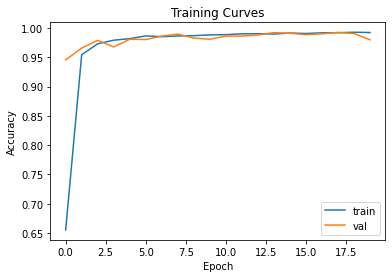

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [75]:
test_data_dir = r"D:\sample15_s1"
testing_data = os.listdir(test_data_dir)
X_test = []

for file in testing_data:
    B_frame = pd.read_csv(test_data_dir + file, header=None).to_numpy()
    plt.imshow(B_frame, cmap="gray")
    plt.show()
    clear_output(wait=True)
    B_frame = B_frame[300:1200, :]
    X_test = X_test + slice_bframe(B_frame, 100, 20)

X_test = np.expand_dims(np.stack(X_test), axis=3)
print(X_test.shape)

KeyboardInterrupt: 

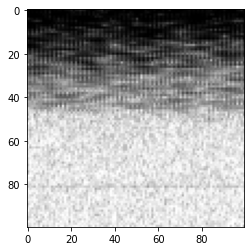

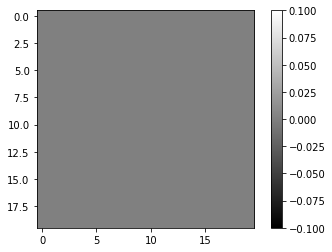

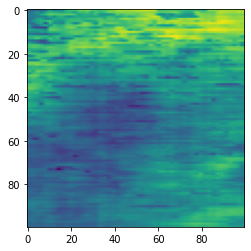

In [71]:
slice = X_test[17,:,:,:]
plt.imshow(resize(slice, (100,100)), cmap='gray')
plt.show()

seg_map = brain_CNN.predict(X_test[0:5120,:,:,:])
seg_map = seg_map > 0.5
seg_map = np.reshape(seg_map[:,0],(256,20))
plt.imshow(resize(seg_map, (20,20)), cmap='gray')
plt.colorbar()
plt.show()

# sample = 564
# test_input = np.expand_dims(X_test[sample, :, :, :], axis=0)
# print(test_input.shape)
# print(brain_CNN.predict(test_input))
# # print(Y_train[sample])

gt_path = r"C:\Users\Nathan\Deep Learning\brain_cancer_oct\data\phantom_3\Processed_Final_D10\ExVivo_Brain_30_T1_2017-10-03_DFT_01.csv"
gt = pd.read_csv(gt_path, header=None).to_numpy()
plt.imshow(resize(gt, (100,100)))
plt.show()